## **Detecting Credit Card Fraud with Machine Learning**

"Payments fraud represents a significant and growing issue in the United States and abroad. There was more than $8 billion in fraud over U.S. non-cash payment systems in 2015, a 37 percent increase from 2012. Financial institutions and payment operators are increasingly relying on machine learning algorithms to develop efficient and effective fraud detection systems. 

In this applied project, I implement and assess the performance of various machine learning models, like **logistic regression**, using a rich dataset from Kaggle. The dataset contains approximately 300,000 credit card transactions occurring over two days in Europe.

A key challenge with payments fraud data is **class imbalance**. In the Kaggle dataset, roughly 99.8 percent of the transactions are labeled as legitimate and 0.2 percent as fraudulent. Class imbalance can make it difficult for standard models to learn to distinguish between the majority and minority classes. 

As part of this project, I explore and assess methods to address this
issue, including sampling techniques such as **undersampling** the majority class and **oversampling** the minority class, before and during cross validation. 

Due to privacy concerns, it is not possible to infer meaningful relationships between most of the variables in the dataset. For this
reason, the focus of my project is on predictive performance rather than inference."

**Sources / Refs** : 
- http://cs229.stanford.edu/proj2019spr/report/32.pdf

- https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/

- https://towardsdatascience.com/credit-card-fraud-detection-9bc8db79b956

- https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba


**Dataset** : https://www.kaggle.com/mlg-ulb/creditcardfraud

### Kaggle API and dataset download

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


 74% 49.0M/66.0M [00:01<00:00, 19.9MB/s]
100% 66.0M/66.0M [00:01<00:00, 45.5MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


### Importing libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/

### Dataset - Loading and Exploration

The datasets contains transactions made by credit cards in September 2013 by european cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

- Except for the transaction and amount we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.

- The transaction amount is relatively small. The mean of all the mounts made is approximately USD 88.

- There are no "Null" values, so we don't have to work on ways to replace values.

- Unbalanced dataset. Most of the transactions were Non-Fraud (99.83%) of the time, while Fraud transactions occurs (0.17%) of the time in the dataframe.

In [4]:
df = pd.read_csv('creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
# Good No Null Values!
df.isnull().sum().max()

0

In [8]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

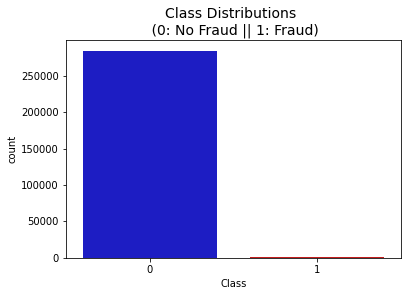

In [9]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

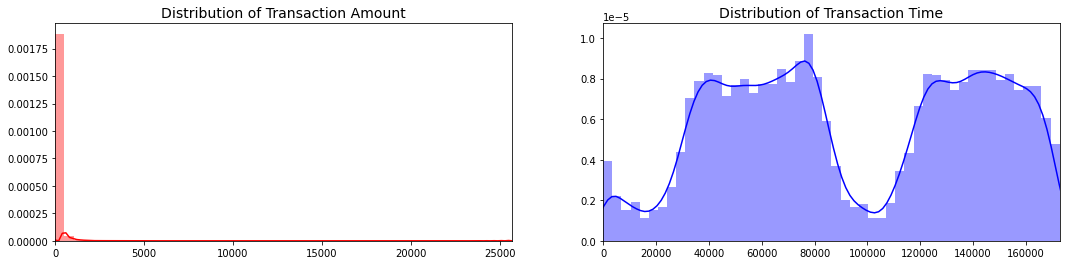

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Preprocessing - Scaling

In [11]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
#rob_scaler = RobustScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head(3)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0


### Preprocessing - Splitting the Data - (df, original_Xtrain, original_ytrain)

---



---



In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### Under-Sampling (new_df)

In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

50/50 ratio : this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.

In [14]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head(3)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
41326,-0.331160,-1.140852,-0.258122,0.557335,0.190181,-0.251512,2.437678,3.673470,-0.226081,0.974771,-0.496447,-0.187835,-0.328845,-0.270236,0.059288,0.270680,1.425708,0.278540,-0.805234,0.768660,0.692110,0.157654,0.122859,0.226644,-0.122199,0.998750,-0.285464,-0.369937,0.198380,0.169892,0
86155,0.052576,-0.709775,-2.756007,0.683821,-1.390169,1.501887,-1.165614,-0.131207,-1.478741,-0.246922,-0.100523,-2.301110,1.914454,-3.830998,0.719489,-6.353020,1.438716,-3.297239,-4.862971,-2.002354,1.545233,-0.106945,0.320474,0.611027,0.174864,-0.502151,-0.174713,1.179242,-1.166315,0.821215,1
199707,-0.130696,0.806163,-0.778256,-0.005699,-0.737169,-1.921642,1.052070,1.248283,-0.057385,0.820473,-1.735050,0.207906,0.454882,0.617242,0.871902,0.591762,0.057851,-1.798084,0.070506,0.669860,-1.763353,-0.329197,0.136570,0.774782,0.073281,-0.904976,-0.746272,0.746892,0.309189,0.136601,0


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


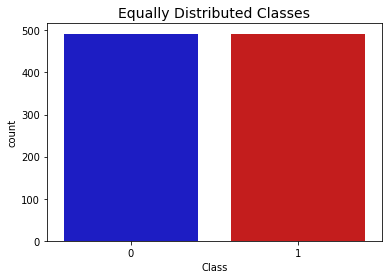

In [15]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Undersampling - Correlation

Entire dataset (df) Vs. Undersampled dataset (new_df)

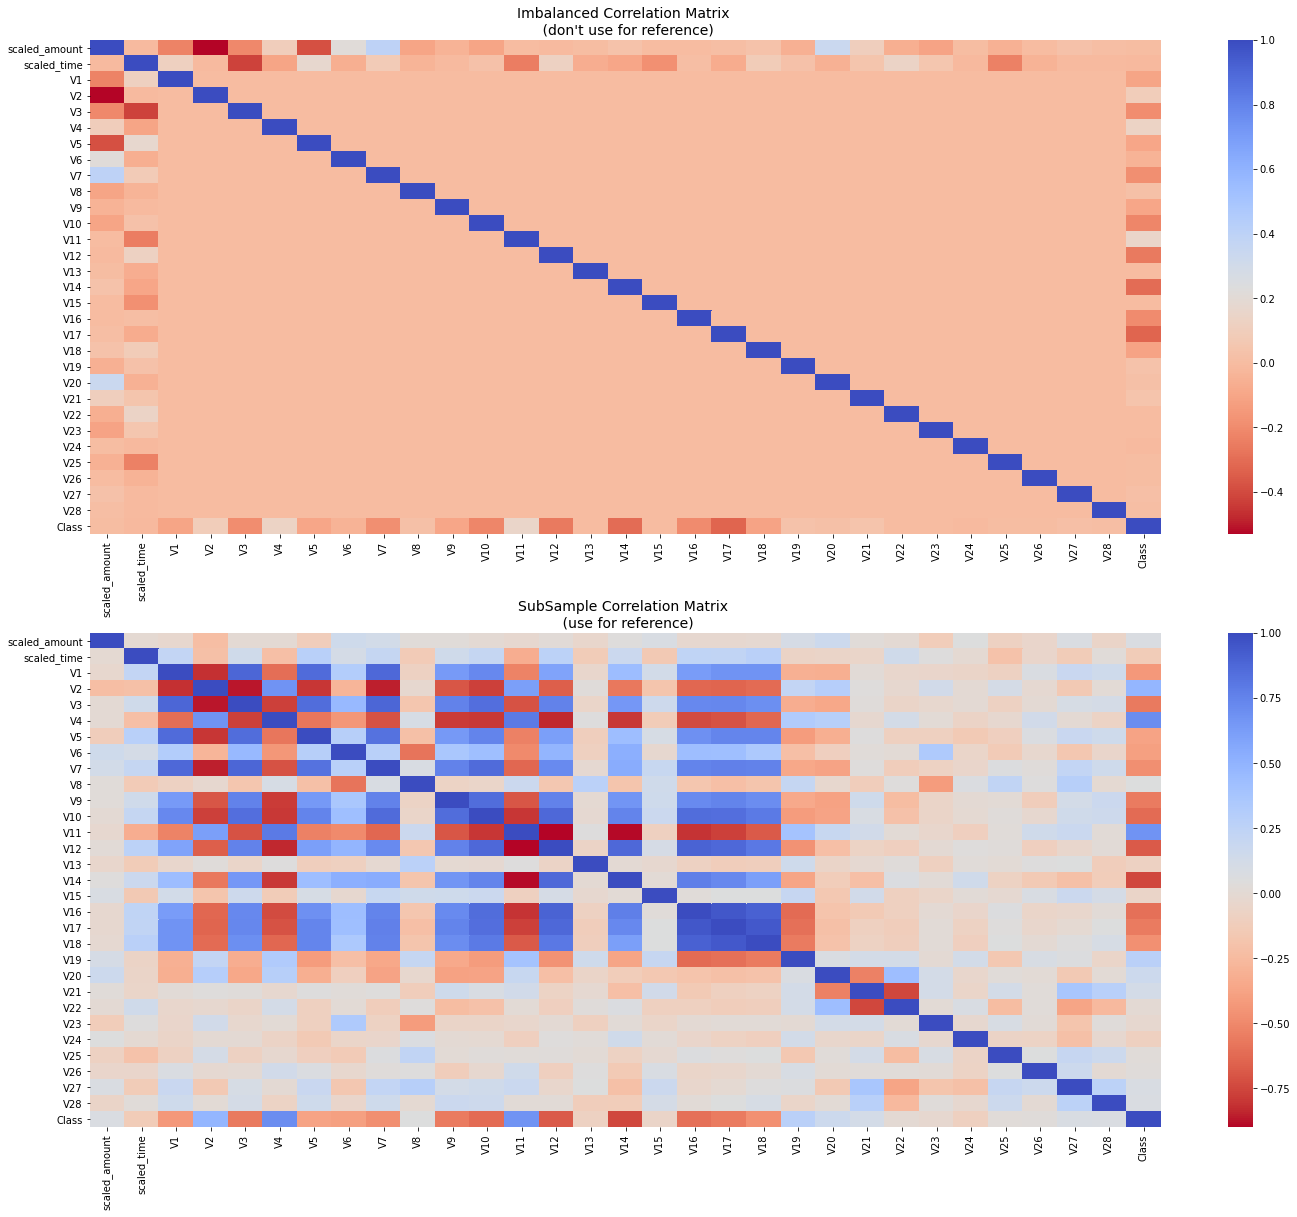

In [16]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame - df
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Undersampled - new_df
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### Undersampling - Correlation (new_df)

**Negative Correlations**: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

**Positive Correlations**: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

**BoxPlots**: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

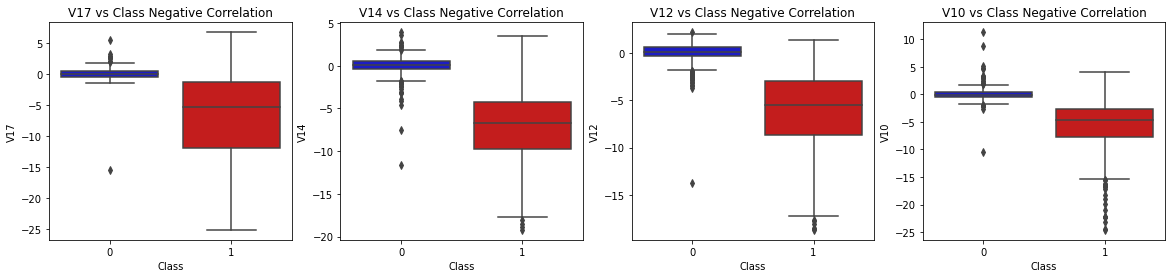

In [17]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

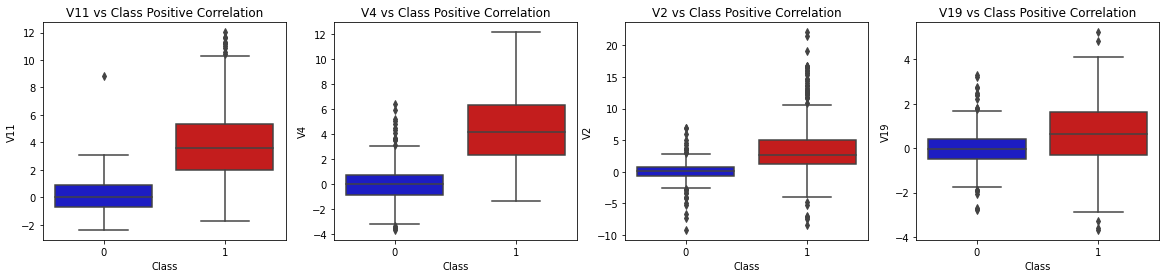

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

### Undersampling - Dimensionality Reduction and Clustering - (X, y)

t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.

In [19]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.1 s
PCA took 0.039 s
Truncated SVD took 0.0042 s


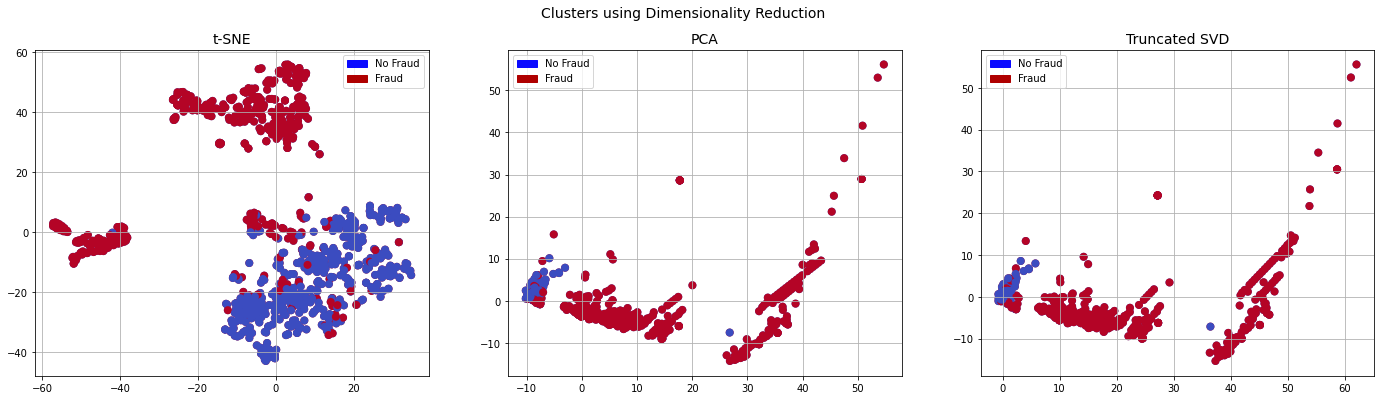

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### Undersampling - (new_df, X_train, y_train) - before cross validating

In [21]:
# Undersampling before cross validating (prone to overfit and overoptimism)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Oversampling - SMOTE - (Xsm_train, ysm_train) - before cross validating

In [22]:
# Undersampling before cross validating
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
Xsm_test, ysm_test = sm.fit_sample(original_Xtest, original_ytest)

### Dataset splits summary : Xs and Ys

In [23]:
# Original
print(df.shape)
# Undersampled
print(new_df.shape)
# Original
print(original_Xtrain.shape)
print(original_Xtest.shape)
# Undersampled
print(X_train.shape)
print(X_test.shape)
# Oversampled
print(Xsm_train.shape)
print(Xsm_test.shape)

(284807, 31)
(984, 31)
(227846, 30)
(56961, 30)
(787, 30)
(197, 30)
(454904, 30)
(113726, 30)


### Modeling - Logistic Regression - with undersampling before cross validation - (X_train, y_train)

In [26]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_
print(log_reg)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.16%


In [28]:
y_pred = log_reg.predict(X_test)

In [29]:
# Confusion matrix
import itertools
import matplotlib.pyplot as plt 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


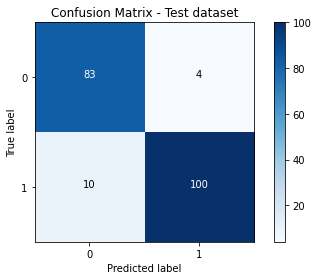

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred.round())
plot_confusion_matrix(cm, classes = [0, 1], title = 'Confusion Matrix - Test dataset')

In [33]:
print(accuracy_score(y_test, y_pred.round()))
print(precision_score(y_test, y_pred.round()))
print(recall_score(y_test, y_pred.round()))
print(f1_score(y_test, y_pred.round()))

0.9289340101522843
0.9615384615384616
0.9090909090909091
0.9345794392523366


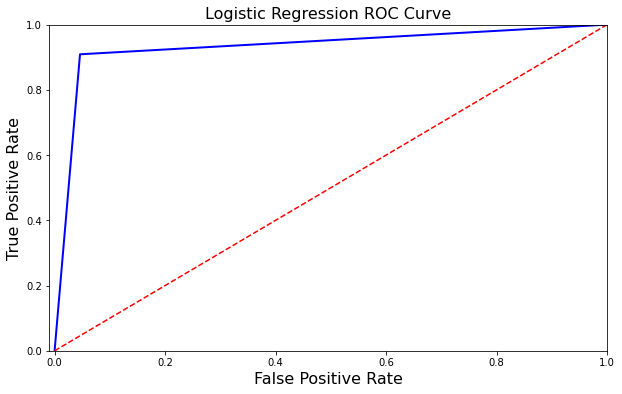

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y_test, y_pred)

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(10,6))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
        
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

### Modeling **- 2 -** Logistic Regression with oversampling before cross validation - (Xsm_train, ysm_train)

In [34]:
# Use GridSearchCV to find the best parameters.

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg_2 = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg_2.fit(Xsm_train, ysm_train)

log_reg_2 = grid_log_reg_2.best_estimator_
print(log_reg_2)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
log_reg_score_2 = cross_val_score(log_reg_2, Xsm_train, ysm_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score_2.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.9%


In [37]:
y_pred_2 = log_reg_2.predict(Xsm_test)

Confusion matrix, without normalization


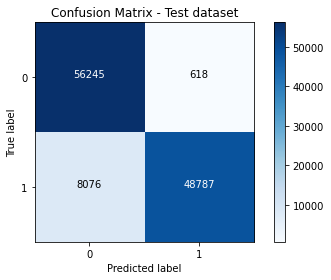

In [38]:
cm_2 = confusion_matrix(ysm_test, y_pred_2.round())
plot_confusion_matrix(cm_2, classes = [0, 1], title = 'Confusion Matrix - Test dataset')

In [39]:
print(accuracy_score(ysm_test, y_pred_2.round()))
print(precision_score(ysm_test, y_pred_2.round()))
print(recall_score(ysm_test, y_pred_2.round()))
print(f1_score(ysm_test, y_pred_2.round()))

0.9235531013136837
0.9874911446209897
0.8579744297697975
0.9181879775661534


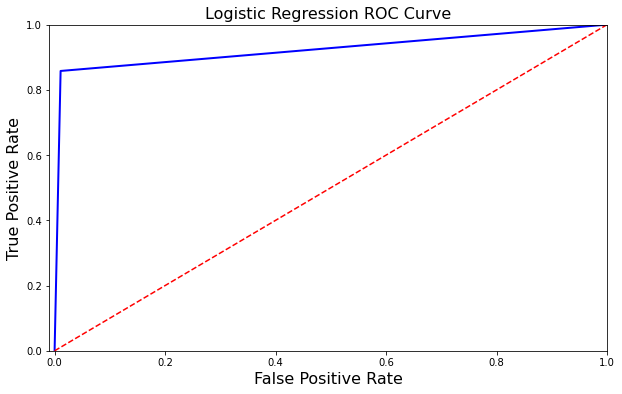

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(ysm_test, y_pred_2)

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(10,6))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
        
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

### Modeling **- 3 -** Logistic Regression - with NearMiss Undersampling during cross validation

In [64]:
# We will undersample during cross validating by Implementing NearMiss Technique 
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Use GridSearchCV to find the best parameters.
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg_3 = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg_3.fit(undersample_Xtrain, undersample_ytrain)
log_reg_3 = grid_log_reg_3.best_estimator_
print(log_reg_3)

# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg_3) 
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 53184  54163  54602 ... 284804 284805 284806] Test: [    0     1     2 ... 56966 56967 56968]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 53184  54163  54602 ... 113923 113924 113925]
Train: [     0      1      2 ... 284804 284805 284806] Test: [112950 113627 113926 ... 170885 170886 170887]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168827 169365 169917 ... 227849 227850 227851]
Train: [     0      1      2 ... 227849 227850 227851] Test: [222226 222445 223243 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [65]:
print('Accuracy List: ', undersample_accuracy)
print('Precision List: ', undersample_precision)
print('Recall List: ', undersample_recall)
print('F1 score List: ', undersample_f1)
print('AUC score List: ', undersample_auc)

Accuracy List:  [0.4358788676761027, 0.649147446729136, 0.5339375452610328, 0.6902060611380544, 0.7138405494963681]
Precision List:  [0.0033747589457895862, 0.0015494089291862734, 0.0011705033164260631, 0.0019227247756821095, 0.00040029354860230835]
Recall List:  [0.44366197183098594, 0.391304347826087, 0.46153846153846156, 0.20588235294117646, 0.20689655172413793]
F1 score List:  [0.0066985645933014355, 0.0030865961703343816, 0.002335084646818447, 0.003809869375907112, 0.0007990411506192569]
AUC score List:  [0.5170563975558911, 0.5044543717152413, 0.5057983407720869, 0.483063023084616, 0.4389445428800751]


In [66]:
print('---' * 45)
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.4f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.4f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Accuracy Score: 0.60
Precision Score: 0.0017
Recall Score: 0.34
F1 Score: 0.0033
---------------------------------------------------------------------------------------------------------------------------------------


In [44]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots(1,1, figsize=(10,7), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg_3, undersample_Xtrain, undersample_ytrain, (0.87, 1.01), cv=cv, n_jobs=4)

In [63]:
from sklearn.metrics import average_precision_score

undersample_y_score = log_reg_3.decision_function(original_Xtest)

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

Average precision-recall score: 0.62


## Modeling - 4 - Logistic Regression - with SMOTE oversampling during cross validation

In [67]:
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

kf = KFold(n_splits=5, random_state=42, shuffle=False)

imba_pipeline = make_pipeline(SMOTE(random_state=42), LogisticRegression())
cross_val_score(imba_pipeline, original_Xtrain, original_ytrain, scoring='recall', cv=kf)

array([0.95070423, 0.89855072, 0.76923077, 0.91176471, 0.86206897])

In [70]:
log_reg_score_4 = cross_val_score(imba_pipeline, original_Xtrain, original_ytrain, scoring='recall', cv=kf)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score_4.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  87.85%


##### Tunning

In [76]:
print(LogisticRegression().get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [98]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
new_params = {'logisticregression__' + key: log_reg_params[key] for key in log_reg_params}

imba_pipeline = make_pipeline(SMOTE(random_state=42, ratio='minority'), LogisticRegression())

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='roc_auc', return_train_score=True)
grid_imba.fit(original_Xtrain, original_ytrain)

print('Best Score: ', grid_imba.best_score_)
print('Best Params: ', grid_imba.best_params_)

Best Score:  0.9568371846627286
Best Params:  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}


In [99]:
grid_imba.best_estimator_

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio='minority',
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [100]:
y_pred_4 = grid_imba.predict(original_Xtest)

In [102]:
print(accuracy_score(original_ytest, y_pred_4.round()))
print(precision_score(original_ytest, y_pred_4.round()))
print(recall_score(original_ytest, y_pred_4.round()))
print(f1_score(original_ytest, y_pred_4.round()))
print(roc_auc_score(original_ytest, y_pred_4.round()))

0.9883429012833342
0.11548913043478261
0.8673469387755102
0.20383693045563547
0.9279491847035141


In [ ]:
log_reg_4 = grid_imba.best_estimator_
print(log_reg_4)

Confusion matrix, without normalization


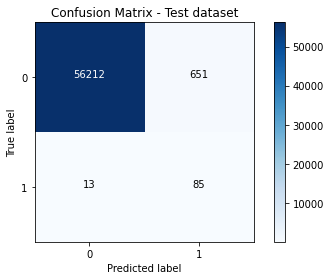

In [103]:
cm_4 = confusion_matrix(original_ytest, y_pred_4.round())
plot_confusion_matrix(cm_4, classes = [0, 1], title = 'Confusion Matrix - Test dataset')

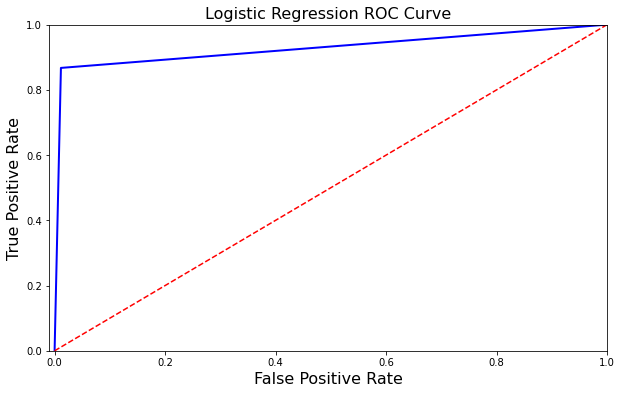

In [104]:
from sklearn.metrics import roc_auc_score, roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(original_ytest, y_pred_4)

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(10,6))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
        
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [106]:
# Sampling during cross validation
print(roc_auc_score(original_ytest, y_pred_4.round()))
print(np.mean(undersample_auc))

# overfitting case - sampling before cross validation
print(roc_auc_score(ysm_test, y_pred_2.round()))
print(roc_auc_score(y_test, y_pred.round()))

0.9279491847035141
0.4898633352015821
0.9235531013136836
0.9315569487983283


In [107]:
# Sampling during cross validation
print(recall_score(original_ytest, y_pred_4.round()))
print(np.mean(undersample_recall))

# overfitting case - sampling before cross validation
print(recall_score(ysm_test, y_pred_2.round()))
print(recall_score(y_test, y_pred.round()))

0.8673469387755102
0.3418567371721698
0.8579744297697975
0.9090909090909091


In [108]:
# Sampling during cross validation
print(precision_score(original_ytest, y_pred_4.round()))
print(np.mean(undersample_precision))

# overfitting case - sampling before cross validation
print(precision_score(ysm_test, y_pred_2.round()))
print(precision_score(y_test, y_pred.round()))

0.11548913043478261
0.001683537903137268
0.9874911446209897
0.9615384615384616


### Savin model 4 - Logistic Regression with SMOTE oversampling during cross 

In [109]:
#from sklearn.externals import joblib
import joblib

joblib.dump(grid_imba, 'model.pkl')

['model.pkl']

In [115]:
original_Xtest[0]

array([-0.35318941,  0.92823624, -1.29844323,  1.94810045, -4.50994689,
        1.30580477, -0.01948593, -0.50923778, -2.64339762,  1.28354519,
       -2.5153557 , -4.50131481,  2.09307501, -5.41888894, -1.24701371,
       -3.82826818,  0.39905034, -6.36649951, -7.55096809, -4.90276667,
        0.15289203,  0.25041544,  1.17803195,  1.36098858, -0.27201306,
       -0.3259479 ,  0.29070267,  0.84129459,  0.64309425,  0.20115575])

In [121]:
joblib_model = joblib.load('model.pkl')

test = np.array(original_Xtest[245])
test = test.reshape(1, -1)
print(original_ytest[245])

joblib_model.predict(test)

0


array([0])